In [140]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [141]:
DATA_PATH = os.path.join("Data", "Dataset_BUSI_with_GT")
MALIGNANT_PATH = os.path.join(DATA_PATH, "malignant")
BENIGN_PATH = os.path.join(DATA_PATH, "benign")
NORMAL_PATH = os.path.join(DATA_PATH, "normal")

IMG_SIZE = (256,256)
random_state = 946

# Creating the Neural Networks

## Image Segmentation Model

### Loading Data

In [142]:
path_list = [MALIGNANT_PATH, BENIGN_PATH]

data_images = list()
target_images = list()
target_names = list()

prev_file = None

for path in path_list:
    img_list = os.listdir(path)
    total_imgs = len(img_list)
    for img_file in img_list:
        img_path = os.path.join(path, img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE)

        if "_mask" in img_file:
            if "_mask" in prev_file:
                loc = len(target_images) - 1
                target_images[loc] = target_images[loc] + img
            else:
                target = img_file.split()[0]
                target_images.append(img)
                target_names.append(target)
            
        else:
            data_images.append(img)
        
        prev_file = img_file
        
print(f"Total Training Images: {len(data_images)}")
print(f"Total Target Images: {len(target_images)}")

In [143]:
X = np.array(data_images)
y_images = np.array(target_images)
y_labels = target_names

X, y_images, y_labels = shuffle(X, y_images, target_names, random_state= random_state)

In [144]:
X = X/255
y_images = y_images/255.
X.shape, y_images.shape

In [145]:
X_train, X_test,\
y_train_img, y_test_img,\
y_train_labels, y_test_labels = train_test_split(X, y_images, y_labels,
                                                 shuffle= True, random_state= random_state)

### Creating the model

In [146]:
def image_segmentation_model(img_shape):
    # num_classes calssifies each pixel as either tumor or not (white or black)
    
    inputs = keras.Input(shape=img_shape)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(64, 3, strides= 2, activation= "relu", padding= "same")(x)
    x = layers.Conv2D(64, 3, activation= "relu", padding= "same")(x)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(128, 3, strides= 2, activation= "relu", padding= "same")(x)
    x = layers.Conv2D(128, 3, activation= "relu", padding= "same")(x)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(256, 3, strides= 2, activation= "relu", padding= "same")(x)
    x = layers.Conv2D(256, 3, activation= "relu", padding= "same")(x)
    
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2DTranspose(256, 3, activation = 'relu', padding = 'same')(x)
    x = layers.Conv2DTranspose(256, 3, strides= 2, activation = 'relu', padding = 'same')(x)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2DTranspose(128, 3, activation = 'relu', padding = 'same')(x)
    x = layers.Conv2DTranspose(128, 3, strides= 2, activation = 'relu', padding = 'same')(x)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')(x)
    x = layers.Conv2DTranspose(64, 3, strides= 2, activation = 'relu', padding = 'same')(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    outputs = layers.Conv2D(1, 3, activation= "sigmoid", padding= "same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [147]:
def unet_down(x, filters):
    x = layers.Conv2D(filters,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    p = layers.MaxPool2D(2)(x)
    p = layers.Dropout(0.2)(p)
    return x, p


def bottleneck(x, filters):
    x = layers.Conv2D(filters,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def unet_up(x, p, filters):
    p = layers.UpSampling2D(2)(p)
    x = layers.Concatenate(axis=-1)([p, x])

    x = layers.Conv2D(filters,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)

    return x


def imseg(input_shape):
    inputs = layers.Input(shape=input_shape)
    x1, p1 = unet_down(inputs, 64)
    x2, p2 = unet_down(p1, 128)
    x3, p3 = unet_down(p2, 256)
    x4, p4 = unet_down(p3, 512)

    p5 = bottleneck(p4, 1024)
    
    p6 = unet_up(x4, p5, 512)
    p7 = unet_up(x3, p6, 256)
    p8 = unet_up(x2, p7, 128)
    p9 = unet_up(x1, p8, 64)
    
    output = layers.Conv2D(1, 1, activation="sigmoid")(p9)
    model = keras.Model(inputs=inputs, outputs=output)

    return model

In [148]:
imseg_model = imseg(IMG_SIZE + (1,))
imseg_model.summary()

In [149]:
imseg_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
callbacks = keras.callbacks.ModelCheckpoint("image_segmentaiton.keras", save_best_only=True)
history = imseg_model.fit(X_train, y_train_img, 
                    epochs = 20,
                    batch_size = 8, 
                    validation_data = (X_test, y_test_img), 
                    callbacks = [callbacks])

In [150]:
epochs = range(1, len(history.history['loss']))

train_acc = history.history['accuracy'][1:]
train_loss = history.history['loss'][1:]

val_acc = history.history['val_accuracy'][1:]
val_loss = history.history['val_loss'][1:]

plt.figure(figsize = (10, 7))
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.plot(epochs, train_loss, 'ro', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title(label = 'Training and Validation Accuracy and Loss')
plt.legend()
plt.show()

### Testing Image Segmentation Model

In [151]:
X_test = X_test.reshape((-1,256,256,1))
X_test.shape

In [152]:
def make_mask(value, threshold= 0.1):
    if value >= threshold:
        return 255
    else:
        return 0
makeMask = np.vectorize(make_mask)

In [153]:
imseg_model = keras.models.load_model("image_segmentaiton.keras")
predictions = imseg_model.predict(X_test)

In [154]:
i = 55
predicted_mask = predictions[i]

test_img = X_test[i]
target_mask = y_test_img[i]

plt.figure(figsize=(9,9))
plt.subplot(1,3,1)
plt.imshow(test_img, cmap="gray")
plt.title("Actual")

plt.subplot(1,3,2)
plt.imshow(target_mask, cmap="gray")
plt.title("Target Map")

plt.subplot(1,3,3)
pm = makeMask(predicted_mask, 0.8)
plt.imshow(pm, cmap= "gray")
plt.title("Predicted Target")

print(y_test_labels[i])

## Mask Classification Model

### Loading all the data

In [155]:
path_list = [MALIGNANT_PATH, BENIGN_PATH, NORMAL_PATH] # this time we include "NORMAL_PATH"

target_images = list()
target_names = list()

prev_file = None

for path in path_list:
    img_list = os.listdir(path)
    total_imgs = len(img_list)
    for img_file in img_list:
        img_path = os.path.join(path, img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE)

        if "_mask" in img_file:
            if "_mask" in prev_file:
                loc = len(target_images) - 1
                target_images[loc] = target_images[loc] + img
            else:
                target = img_file.split()[0]
                target_images.append(img)
                target_names.append(target)
            
        prev_file = img_file
        
print(f"Total Training Images: {len(data_images)}")
print(f"Total Target Images: {len(target_images)}")
print(f"Total Target Labels: {len(target_names)}")

Total Training Images: 780
Total Target Images: 780
Total Target Labels: 780


In [156]:
X= np.array(target_images)
y = target_names

# encode strings to numbers
unique_targets = list(set(y))
target_encode = dict()
target_decode = dict()
print(unique_targets)
for i, target in enumerate(unique_targets):
    target_encode[target] = i
    target_decode[i] = target
y = [target_encode[t] for t in y]
y = np.array(y, dtype= int)
y = y.reshape((-1,1))

X, y = shuffle(X, y, random_state= random_state)

X = X/255.

['malignant', 'normal', 'benign']


In [157]:
X_train, X_test,\
y_train, y_test = train_test_split(X, y, shuffle= True, random_state= random_state)

In [158]:
X_train.shape, X_test.shape

((585, 256, 256), (195, 256, 256))

In [159]:
y_train.shape

(585, 1)

### Creating Model

In [160]:
def mask_classifier(img_size, classes= 3):
    inputs = layers.Input(shape= img_size)
    
    x = layers.Conv2D(32, 3, strides= 2, activation= "relu")(inputs)
    x = layers.MaxPool2D(2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(64, 3, strides= 2, activation= "relu")(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, 3, strides= 2, activation= "relu")(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation= "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation= "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation= "relu")(x)
    
    outputs = layers.Dense(classes, activation= "Softmax")(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [161]:
mask_classifier_model = mask_classifier(IMG_SIZE + (1,))
mask_classifier_model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 127, 127, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                      

In [162]:
mask_classifier_model = mask_classifier(IMG_SIZE + (1,))

optimizer = keras.optimizers.Adam(0.0001)

mask_classifier_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callbacks = keras.callbacks.ModelCheckpoint("image_classification.keras", save_best_only=True)
history = mask_classifier_model.fit(X_train, y_train, 
                    epochs = 80,
                    batch_size = 32, 
                    validation_data = (X_test, y_test), 
                    callbacks = [callbacks])

Epoch 1/80
19/19 [==============================] - 2s 86ms/step - loss: 1.0681 - accuracy: 0.3385 - val_loss: 1.0302 - val_accuracy: 0.5077
Epoch 2/80
19/19 [==============================] - 0s 23ms/step - loss: 0.9375 - accuracy: 0.4769 - val_loss: 0.8961 - val_accuracy: 0.6000
Epoch 3/80
19/19 [==============================] - 1s 28ms/step - loss: 0.8243 - accuracy: 0.5402 - val_loss: 0.7977 - val_accuracy: 0.5795
Epoch 4/80
19/19 [==============================] - 0s 23ms/step - loss: 0.7722 - accuracy: 0.5624 - val_loss: 0.7508 - val_accuracy: 0.6103
Epoch 5/80
19/19 [==============================] - 0s 21ms/step - loss: 0.7336 - accuracy: 0.5778 - val_loss: 0.7372 - val_accuracy: 0.6205
Epoch 6/80
19/19 [==============================] - 0s 22ms/step - loss: 0.7404 - accuracy: 0.5590 - val_loss: 0.7169 - val_accuracy: 0.6205
Epoch 7/80
19/19 [==============================] - 0s 22ms/step - loss: 0.7086 - accuracy: 0.6855 - val_loss: 0.6982 - val_accuracy: 0.7897
Epoch 8/80
19

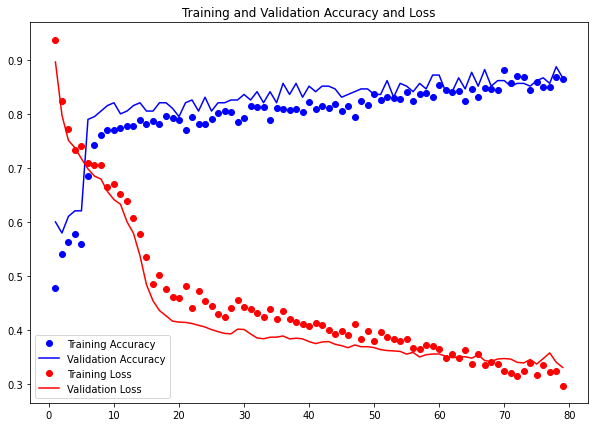

In [163]:
epochs = range(1, len(history.history['loss']))

train_acc = history.history['accuracy'][1:]
train_loss = history.history['loss'][1:]

val_acc = history.history['val_accuracy'][1:]
val_loss = history.history['val_loss'][1:]

plt.figure(figsize = (10, 7))
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.plot(epochs, train_loss, 'ro', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title(label = 'Training and Validation Accuracy and Loss')
plt.legend()
plt.show()

### Testing Model

In [164]:
predicted_labels = np.argmax(mask_classifier_model.predict(X_test), axis= 1)

In [165]:
i = 16

test_img = X_test[i]
test_label = target_decode[y_test[i][0]]
predicted_label = target_decode[predicted_labels[i]]

plt.imshow(test_img)
plt.show()

print(f"Actual: {test_label}")
print(f"Predicted: {predicted_label}")

In [166]:
j = 7

test_img = X_test[j]
test_label = target_decode[y_test[j][0]]
predicted_label = target_decode[predicted_labels[j]]

plt.imshow(test_img)
plt.show()

print(f"Actual: {test_label}")
print(f"Predicted: {predicted_label}")

In [167]:
k = 0

test_img = X_test[k]
test_label = target_decode[y_test[k][0]]
predicted_label = target_decode[predicted_labels[k]]

plt.imshow(test_img)
plt.show()

print(f"Actual: {test_label}")
print(f"Predicted: {predicted_label}")

# Concatenating Both Models

In [168]:
def make_mask(threshold=0.1):
    def fn(x):
        greater = keras.greater_equal(x, threshold) #will return boolean values
        greater = keras.cast(greater, dtype=K.floatx()) #will convert bool to 0 and 1    
        return greater
    return fn

## Loading Data

In [169]:
path_list = [MALIGNANT_PATH, BENIGN_PATH, NORMAL_PATH] # this time we include "NORMAL_PATH"


data_images = list()
target_images = list()
target_names = list()

prev_file = None

for path in path_list:
    img_list = os.listdir(path)
    total_imgs = len(img_list)
    for img_file in img_list:
        img_path = os.path.join(path, img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE)

        if "_mask" in img_file:
            if "_mask" in prev_file:
                loc = len(target_images) - 1
                target_images[loc] = target_images[loc] + img
            else:
                target = img_file.split()[0]
                target_images.append(img)
                target_names.append(target)
            
        else:
            data_images.append(img)
        
        prev_file = img_file
        
print(f"Total Training Images: {len(data_images)}")
print(f"Total Target Images and Labels: {len(target_images)}")

Total Training Images: 780
Total Target Images and Labels: 780


In [170]:
X = np.array(data_images)
y = target_names

# encode strings to numbers
unique_targets = list(set(y))
target_encode = dict()
target_decode = dict()
print(unique_targets)
for i, target in enumerate(unique_targets):
    target_encode[target] = i
    target_decode[i] = target
y = [target_encode[t] for t in y]
y = np.array(y, dtype= int)
y = y.reshape((-1,1))

X, y = shuffle(X, y, random_state= random_state)

X = X/255.

['malignant', 'normal', 'benign']


In [171]:
X_train, X_test,\
y_train, y_test = train_test_split(X, y, shuffle= True, random_state= random_state)

## Creating Merged Neural Network

In [172]:
def get_imseg_classifier(img_size):
    imseg_model = keras.models.load_model("image_segmentaiton.keras")
    classifier_model = keras.models.load_model("image_classification.keras")
    
    imseg_output = imseg_model.output
    # x = layers.Lambda(make_mask(threshold= 0.9))(imseg_output)
    classifier_output = classifier_model(imseg_output)
    
    model = keras.Model(imseg_model.input, classifier_output)
    return model

In [173]:
merged_model = get_imseg_classifier(IMG_SIZE + (1,))
merged_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [174]:
predictions = np.argmax(merged_model.predict(X_test[:20]), axis= 1)

1/1 [==============================] - 0s 491ms/step


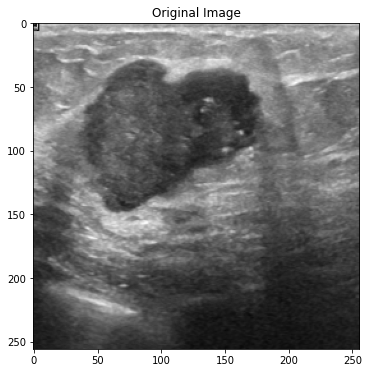

Actual Label: malignant
Predicted Label Label: malignant


In [175]:
i = 16
test_img = X_test[i]
test_label = target_decode[y_test[i][0]]
predicted_label = target_decode[predictions[i]]

plt.figure(figsize=(6,6))
plt.imshow(test_img, cmap= "gray")
plt.title("Original Image")
plt.show()

print(f"Actual Label: {test_label}")
print(f"Predicted Label Label: {predicted_label}")

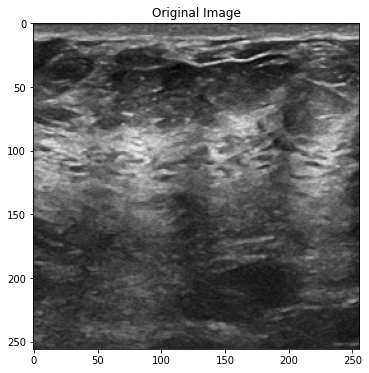

Actual Label: normal
Predicted Label Label: normal


In [176]:
i = 0
test_img = X_test[i]
test_label = target_decode[y_test[i][0]]
predicted_label = target_decode[predictions[i]]

plt.figure(figsize=(6,6))
plt.imshow(test_img, cmap= "gray")
plt.title("Original Image")
plt.show()

print(f"Actual Label: {test_label}")
print(f"Predicted Label Label: {predicted_label}")

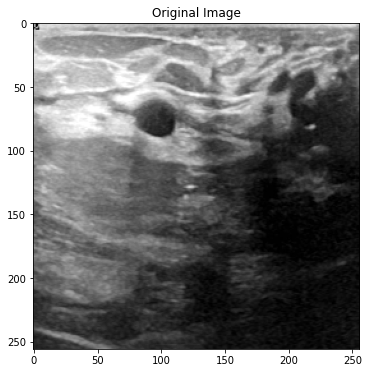

Actual Label: benign
Predicted Label Label: benign


In [177]:
i = 14
test_img = X_test[i]
test_label = target_decode[y_test[i][0]]
predicted_label = target_decode[predictions[i]]

plt.figure(figsize=(6,6))
plt.imshow(test_img, cmap= "gray")
plt.title("Original Image")
plt.show()

print(f"Actual Label: {test_label}")
print(f"Predicted Label Label: {predicted_label}")